In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.ndimage

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Define helping functions for data processing

# Normalize the data to [0, 1] range
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Select data for a given [x_start, x_stop] range
def data_xslice(x, data, x_start, x_stop):
    x_start = np.argwhere(np.isclose(x, x_start, atol=0.01)).flatten()[0]
    x_stop = np.argwhere(np.isclose(x, x_stop, atol=0.01)).flatten()[0]
    x_sliced = x[x_start : x_stop]
    data_sliced = np.array(data)[x_start : x_stop]
    return x_sliced, data_sliced

# Estimate switching time from data for a given [x_start, x_stop] range, plot and save figure 
def find_switching_time(time, data, x_start, x_stop, cross_tol=0.01, show_fig=True, save_fig=False, label_fontsize=16):
    xs, ys = data_xslice(time, data, x_start, x_stop)
    hist, bins = np.histogram(ys, bins=100)
    hist = hist / np.max(hist)
    hist_peaks, _ = scipy.signal.find_peaks(hist, 0.3)
    peaks_values = bins[hist_peaks]
    hi_level = np.max(peaks_values)
    lo_level = np.min(peaks_values)
    peak_to_peak = hi_level - lo_level
    upper_level = hi_level - 0.1 * peak_to_peak
    lower_level = lo_level + 0.1 * peak_to_peak
    upper_cross_frst = np.argwhere(np.isclose(ys, upper_level, atol=cross_tol)).flatten()[0]
    lower_cross_frst = np.argwhere(np.isclose(ys, lower_level, atol=cross_tol)).flatten()[0]
    switch_time = np.round(xs[lower_cross_frst] - xs[upper_cross_frst], decimals=1)
    if show_fig:
        plt.plot(xs,ys, 'o', color='C3')
        plt.plot(xs[upper_cross_frst], ys[upper_cross_frst], 'o', color='C0')
        plt.plot(xs[lower_cross_frst], ys[lower_cross_frst], 'o', color='C0')
        plt.axhline(y=upper_level, color='C0', linestyle='--')
        plt.axhline(y=lower_level, color='C0', linestyle='--')
        plt.axvline(x=xs[upper_cross_frst], color='C0', linestyle='--')
        plt.axvline(x=xs[lower_cross_frst], color='C0', linestyle='--')
        plt.annotate('', xy=(xs[upper_cross_frst], 0.1), xytext=(xs[lower_cross_frst], 0.1), xycoords='data', textcoords='data', arrowprops=(dict(arrowstyle='<->', connectionstyle='arc3', color='C0') ))
        plt.text(xs[upper_cross_frst] + 0.33*switch_time, 0.06, str(switch_time)+' ns' )
        plt.ylim(0,1)
        plt.xlim(xs[0], xs[-1])
        plt.ylabel('Intensity, a.u.', fontsize=label_fontsize)
        plt.xlabel('Time, ns', fontsize=label_fontsize)
        plt.grid()
        if save_fig:
            plt.savefig(fname='switching_time_'+str(switch_time)+'_ns.pdf', format='pdf' )
    return switch_time

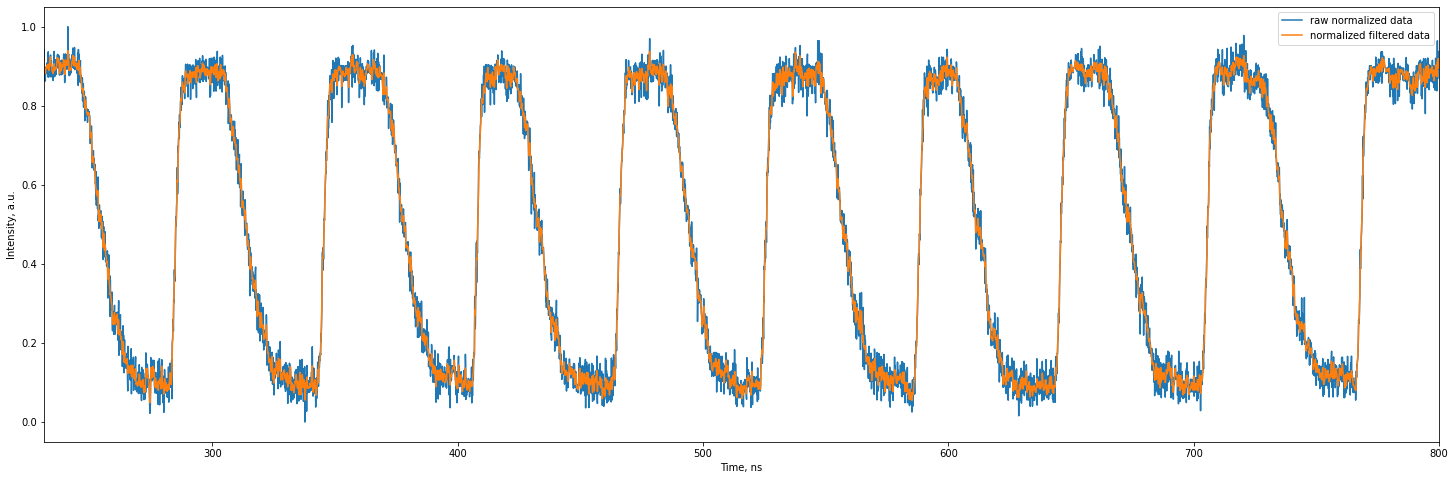

In [3]:
# Load and prepare the data for futher proccessing
x, y = np.loadtxt('switching_time_data.csv', delimiter=';', unpack=True)

# Select the relevant region, i.e. where the modulation occurs
x = 1e+9*np.array(x) 
x_start = np.argwhere(np.isclose(x, 231.5, atol=0.01)).flatten()[0]
x_stop = np.argwhere(np.isclose(x, 800, atol=0.01)).flatten()[0]
x = x[x_start : x_stop]
y = np.array(y)[x_start : x_stop] 
y_raw = normalize_data(y)
y = scipy.ndimage.gaussian_filter1d(y_raw, sigma=1)

# Plot the raw and filtered data for preview
plt.figure(figsize=(25,8))
plt.plot(x, y_raw, label='raw normalized data')
plt.plot(x, y, label='normalized filtered data')
plt.xlim(231.5, 800)
plt.ylabel('Intensity, a.u.')
plt.xlabel('Time, ns')
plt.legend()

Estimated switching times:  [15.4, 16.0, 16.1, 16.3, 16.6, 16.3, 15.6, 17.0, 16.0]
Mean switching time:  16.1


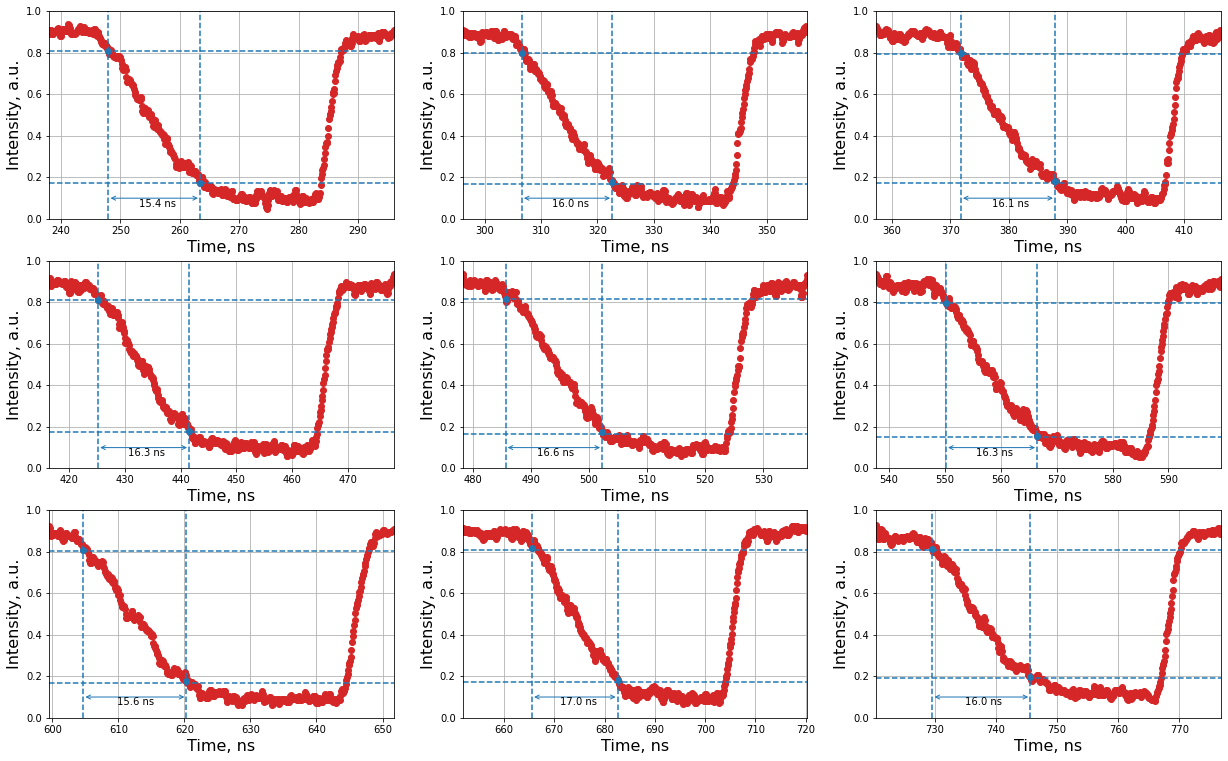

In [4]:
# Mean switching time estimation

# Detect peaks in the data 
y_peaks, _ = scipy.signal.find_peaks(y, height=0.8, width=50) 

# Get the peaks widths to estimate regions where switching occurs 
yw, ywh, yl, yr = scipy.signal.peak_widths(y, y_peaks, rel_height= 0.5) 

plt.figure(figsize=(21,13))
switch_times = []
for i in range(-1, len(y_peaks) - 1):
    
    if i == -1: 
        idx_start = int(y_peaks[0] - 2*yw[0])
        idx_stop  =int(y_peaks[0])

    elif i >= 0 and i < len(y_peaks) - 1:
        idx_start = int(y_peaks[i])
        idx_stop  = int(y_peaks[i+1])

    elif i == len(y_peaks) - 1:
        idx_start = int(y_peaks[-1])
        idx_stop  =int(y_peaks[-1] + 2*yw[-1])
    else: break
    
    plt.subplot(3,3,i+2)
    time = find_switching_time(x,y, x[idx_start], x[idx_stop], show_fig=True)
    switch_times.append(time)

print('Estimated switching times: ', switch_times)
mean_switch_time = np.round(np.mean(switch_times), decimals=1)
print('Mean switching time: ', mean_switch_time)

16.1

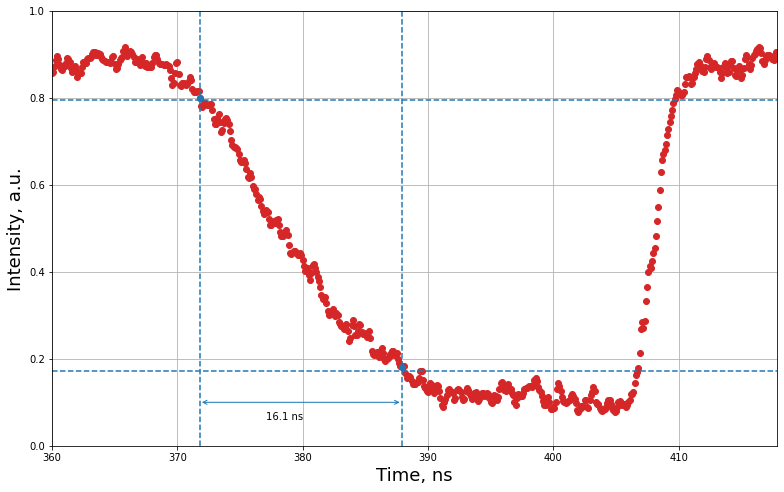

In [5]:
# Display plot with estimated switching time from 360-418 ns region 
# Save figure
# This particular switching time matches the estimated mean, therefore is chosen for presentation
plt.figure(figsize=(13,8))
find_switching_time(x, y, 360, 418, show_fig=True, save_fig=True, label_fontsize=18)